## Chronos_Fx-Variable Importance


In [2]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['dI_t', 'VIX', 'Q', 'SP500', 'OBX_Energy', 'EUR_NOK', 'OSEBX', 'd_pi', 'Brent', 'StoxEurope']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – past covariates) ===
Observations: 308
RMSE (level): 0.141516
MAE  (level): 0.096316
Directional accuracy: 208/307 (67.8%)

=== Diebold–Mariano vs Random Walk (past covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.5571
p-value     : 0.0106


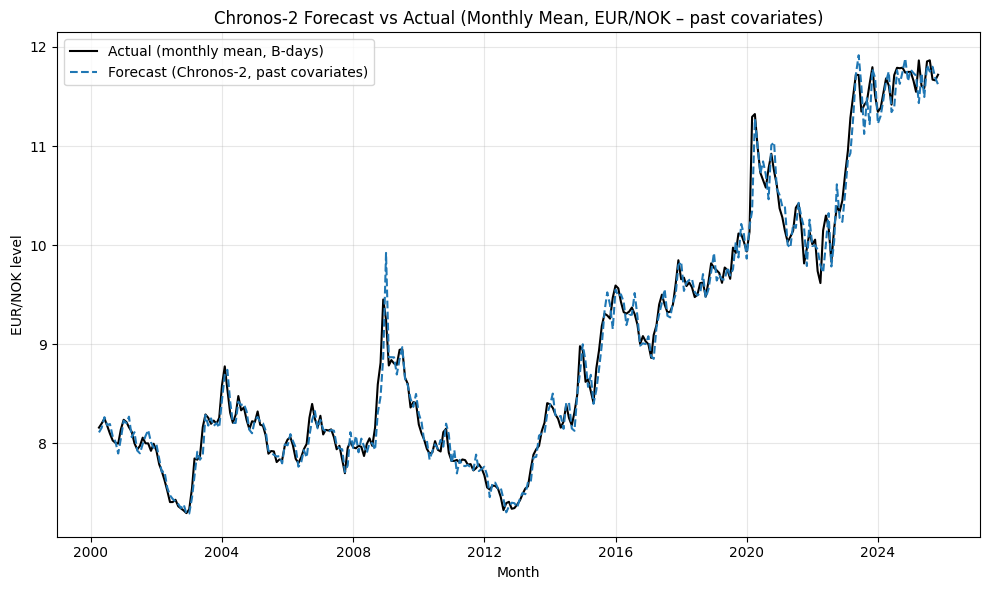

Saved: Chronos2M_daily_pastcov.png
Saved: Chronos2M_daily_pastcov.pdf


In [4]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - Exogenous: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy + macro cols
              passed as past-only covariates in context_df
  - Cut: last business day of previous month (EUR_NOK B-days)
  - Forecast: next calendar month daily -> aggregated to monthly B-day mean
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_pastcov.png"
    fig_pdf: str = "Chronos2M_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
EXOG_COLS = [
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with ffill
      DF_d : daily (D) wide DataFrame with TARGET + covariates (calendar days, ffill)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {
        "Date", "EUR_NOK", "Q", "d_pi", "dI_t",
        "Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"
    }
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # numeric
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["EUR_NOK"])

    # business-day EUR_NOK
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # daily wide with ffill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Build SINGLE-SERIES context_df with past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <ALL_COV_COLS>]
    One item only (EUR_NOK). Exogenous + macros are covariates.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in ALL_COV_COLS:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """
        context_df includes past values of covariates.
        future_df is NOT passed => all covariates are treated as past-only.
        """
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # explicitly disable cross-learning
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward (unchanged logic, new context builder)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:

    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy()
        df_fx = df_fx.sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float, name="point")
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df

# -----------------------------
# Evaluation / DM / Plot (samme som før)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – past covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (past covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, past covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – past covariates)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)

    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
